In [1]:
import geopandas
import pandas
import shapely
import matplotlib.pyplot as plt

### Download data

In [2]:
# City pools
pools = geopandas.read_file(
    "https://services7.arcgis.com/DSSF7DFVxfZsz379/ArcGIS/rest/services/"
    "LARAP_Daily_Pool_Operations_Report_v1_Public/FeatureServer/0/query?"
    "where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope"
    "&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0"
    "&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*"
    "&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint"
    "&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation="
    "&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&"
    "returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false"
    "&returnDistinctValues=false&cacheHint=false&orderByFields="
    "&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset="
    "&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true"
    "&quantizationParameters=&sqlFormat=none&f=pgeojson&token="
)
# There is an error for Westchester pool: it's mistakenly put in Westwood
pools.loc[
    pools.Aquatic_Center.str.contains("Westchester"),
    "geometry",
] = shapely.geometry.Point(-118.416435, 33.957728)

In [3]:
# City council districts
districts = geopandas.read_file(
    "https://opendata.arcgis.com/api/v3/datasets/76104f230e384f38871eb3c4782f903d_13/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)
districts = (
    districts
    [["District", "NAME", "geometry"]]
    .rename(columns={"District": "Council District", "NAME": "Councilmember"})
    .set_index("Council District")
)

In [4]:
# Census blocks with 2020 population
blocks = geopandas.read_file(
    "https://opendata.arcgis.com/api/v3/datasets/8a29319474fe44bb96152d0be8e778af_16/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)

In [5]:
pools = pools[pools.Type.isin(["Seasonal", "Year-Round"])]
pools[~pools.Pool_Closure_Reason.isna()]

,Council_District,Aquatic_Center,Address,Phone_Number,Weekday_Hours,Weekend_Hours,Type,Status,Pool_Closure_Reason,Note,Last_Updated,Image_URL,ObjectId,geometry
50,14,Costello Pool,"3121 E. Olympic Blvd, Los Angeles, CA 90023",323-526-3073,10AM-7PM,1PM-5PM,Seasonal,Closed,Other,Closed Until Further Notice,1662422400000,https://www.laparks.org/sites/default/files/st...,51,POINT (-118.21068 34.02055)
51,4,Griffith Park Pool,"3401 Riverside Dr, Los Angeles, CA 90027",323-644-6878,3p-7p,1PM-5PM,Seasonal,Closed,Mechanical,Closed Until Further Notice,1662422400000,https://www.laparks.org/sites/default/files/st...,52,POINT (-118.27084 34.11781)
52,15,Peck Park Pool,"560 N. Western Ave, San Pedro, CA 90732",310-548-2434,11AM-7PM,1PM-5PM,Year-Round,Closed,Other,Closed Until Further Notice,1662422400000,https://www.laparks.org/sites/default/files/st...,53,POINT (-118.30591 33.75155)
53,7,Verdugo Hills Pool,"10654 Irma Ave, Tujunga, CA 91042",818-353-1365,11AM-7PM,1PM-5PM,Seasonal,Closed,Other,Winter 2023,1662422400000,https://www.laparks.org/sites/default/files/st...,54,POINT (-118.30051 34.26293)


In [6]:
open_pools = pools[pools.Pool_Closure_Reason.isna()]

In [7]:
year_round = open_pools[open_pools.Type == "Year-Round"]
seasonal = open_pools[open_pools.Type == "Seasonal"]

### Which council districts have the most pools?

In [8]:
year_round_pools_by_district = (
    geopandas
    .sjoin(districts, year_round, how="left", predicate="contains")
    .groupby(["Council District", "Councilmember"])
    .Aquatic_Center
    .count()
    .sort_values()
    .rename("year_round")    
)

total_pools_by_district = (
    geopandas
    .sjoin(districts, open_pools, how="left", predicate="contains")
    .groupby(["Council District", "Councilmember"])
    .Aquatic_Center
    .count()
    .sort_values()
    .rename("pools")    
)
pools_by_district = (
    pandas.concat(
        [year_round_pools_by_district, total_pools_by_district],
        axis=1,
    )
    .sort_values(["year_round", "pools"])
)
pools_by_district

,,year_round,pools
Council District,Councilmember,,
13,Hugo Soto-Martinez,0,1
2,Paul Krekorian,0,2
12,John Lee,0,2
3,Bob Blumenfield,0,3
6,Vacant,0,3
5,Katy Yaroslavsky,1,4
11,Traci Park,1,5
1,Eunisses Hernandez,2,2
4,Nithya Raman,2,2


### Assign each census block to a district

In [9]:
cityofla = districts.geometry.unary_union

la_blocks = blocks[blocks.intersects(cityofla)]

# Compute population density in ppl/sqmi for la_blocks
la_blocks = la_blocks.assign(
    density=la_blocks.POP20/la_blocks.to_crs(epsg=2229).area*5280.*5280.
)

# Duplicate the geometry column so that it survives the initial sjoin.
districts_extra = districts.assign(district_geom = districts.geometry).reset_index()
la_blocks_with_districts = geopandas.sjoin(la_blocks, districts_extra, how="inner", predicate="intersects")

# Identify duplicated census blocks -- they intersect more than one district
straddlers = la_blocks_with_districts[la_blocks_with_districts.CTCB20.duplicated(keep=False)]

# Of the duplicates, find the council district with the largest intersection
keep = (
    straddlers
    .assign(intersection=straddlers.geometry.intersection(straddlers.district_geom).area)
    .sort_values(by=["CTCB20", "intersection"], ascending=False)
    .drop_duplicates("CTCB20", keep="first")
)

# Reassemble the census blocks dataset with only the ones we kept of the duplicates
la_blocks_with_districts_dedup = pandas.concat([
    la_blocks_with_districts[~la_blocks_with_districts.index.isin(straddlers.index)],
    keep
]).drop(columns=["index_right"])

/tmp/ipykernel_43116/1968459959.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .assign(intersection=straddlers.geometry.intersection(straddlers.district_geom).area)


### Assemble data for some other public pools

In [10]:
# Neighboring cities
neighboring_cities = geopandas.GeoDataFrame.from_records([
    {
        "Aquatic_Center": "Verdugo Aquatic Facility",
        "geometry": shapely.geometry.Point(-118.339260, 34.162928),
    },
    {
        "Aquatic_Center": "Pacific Community Pool",
        "geometry": shapely.geometry.Point(-118.264775, 34.138913),
    },
    {
        "Aquatic_Center": "Santa Monica Swim Center",
        "geometry": shapely.geometry.Point(-118.472878, 34.015967),
    },
    {
        "Aquatic_Center": "West Hollywood Aquatic Center",
        "geometry": shapely.geometry.Point(-118.384776, 34.081422),
    },
]).set_crs(epsg=4326)

In [11]:
# County pools
import requests
from io import StringIO

data = requests.get(
    "https://locator.lacounty.gov/parks/api/Search?lat=34.0918272&lon=-118.2892032"
    "&tags=43965&page=1&pageSize=100&find=&countyOnly=true&maxDistance=30"
).json()
             

gdfs = []
for park in data["results"]:
    gdfs.append(geopandas.read_file(StringIO(park["geoJSON"])))
    #display({"text/markdown": f"## {park['name']}"}, raw=True)
    #display({"text/html": park["hours"]}, raw=True)
    
county_pools = pandas.concat(gdfs)

year_round_county_pools = county_pools[
    county_pools.Name.isin([
        "Belvedere Community Regional Park",
        "Jesse Owens Community Regional Park",
        "San Fernando Recreation Park and Aquatic Center",
    ])
]

In [12]:
community_colleges = geopandas.GeoDataFrame.from_records([
    {
        "Aquatic_Center": "Los Angeles City College",
        "Council_District": 13,
        "geometry": shapely.geometry.Point(-118.294525, 34.088159),
    },
    {
        "Aquatic_Center": "Los Angeles Trade Technical College",
        "Council_District": 9,
        "geometry": shapely.geometry.Point(-118.272236, 34.030375),
    },
    {
        "Aquatic_Center": "Pierce College",
        "Council_District": 3,
        "geometry": shapely.geometry.Point(-118.573971, 34.184819),
    }
]).set_crs(epsg=4326)

### Which council districts have the largest population that lives more than a mile from a pool?

In [13]:
# This analysis can be run with or without including the public pools
# in Burbank, Glendale, West Hollywood, and Santa Monica.
# They do provide access for non-residents, but usually at significanyly
# higher fees.
open_pools_all = pandas.concat([
    open_pools,
    county_pools,
    #neighboring_cities,
])

In [14]:
# Two miles is a little bit arbitrary, but not a lot. If anything, it's a bit high
# for "easy" access to a pool. Typical definitions for a neighborhood being park-poor
# is if they are more than half a mile from a public park. However, it makes sense for
# a radius for pool access to be a larger than park access, as pools require more
# infrastructure. For LA specifically, two miles does a pretty good job drawing out
# the differences between neighborhoods that have a lot of pools, such that almost
# everyone has is within that radius, and neighborhoods that have no pools, such that
# almost nobody is within that radius.
RADIUS = 5280.*2

In [15]:
total_pool_access_pop = (
    la_blocks_with_districts_dedup[
        la_blocks_with_districts_dedup
        .intersects(
            open_pools_all
            .to_crs(epsg=2229)
            .buffer(RADIUS)
            .to_crs(epsg=4326)
            .unary_union
        )
    ]
    .groupby(["Council District", "Councilmember"])
    .POP20
    .sum()
    .sort_values()
    .rename("access_pop")
)
total_pool_access_pop

Council District  Councilmember          
12                John Lee                   183447.0
4                 Nithya Raman               199496.0
6                 Vacant                     206668.0
15                Tim McOsker                218129.0
7                 Monica Rodriguez           220934.0
10                Heather Hutt               226742.0
13                Hugo Soto-Martinez         228073.0
1                 Eunisses Hernandez         238506.0
3                 Bob Blumenfield            239099.0
2                 Paul Krekorian             247506.0
11                Traci Park                 259682.0
8                 Marqueece Harris-Dawson    263451.0
5                 Katy Yaroslavsky           264120.0
9                 Curren D. Price Jr.        265049.0
14                Kevin de León              276068.0
Name: access_pop, dtype: float64

<AxesSubplot: >

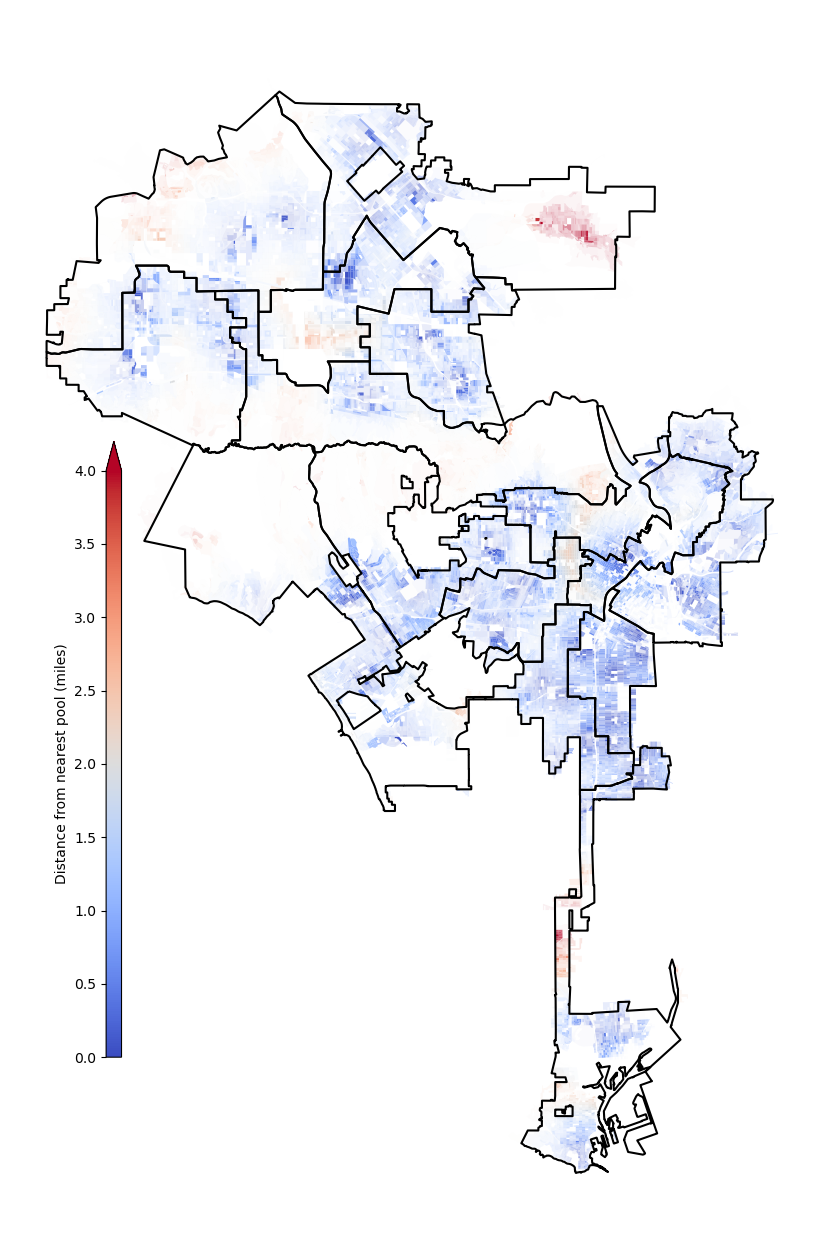

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16,16))
plt.axis("off")
x = (
    geopandas
    .sjoin_nearest(
        la_blocks_with_districts_dedup.to_crs(epsg=2229),
        open_pools_all.to_crs(epsg=2229),
        distance_col="distance",
    )
    .to_crs(epsg=4326)
)
x.plot(
    ax=ax,
    column=x["distance"]/5280.,
    cmap="coolwarm",
    legend=True,
    vmin=0,
    vmax=RADIUS*2/5280.,
    figsize=(16,16),
    alpha=x.density.clip(0, 50_000)/50_000,
    legend_kwds={
        "orientation": "vertical",
        "label": "Distance from nearest pool (miles)",
        "shrink": 0.5,
        "aspect": 40,
        "pad": -.2,
        "location": "left",
        "anchor": (0.2, 0.3),
        "extend": "max",
    }
)
districts.boundary.plot(
    ax=ax,
    color="k"
)

### Which council districts have the largest population more than a mile from a year-round pool?

In [17]:
year_round_all = pandas.concat([
    year_round,
    year_round_county_pools,
    # neighboring_cities,
])

In [18]:
year_round_pool_access_pop = (
    la_blocks_with_districts_dedup[
        la_blocks_with_districts_dedup
        .intersects(
            year_round_all
            .to_crs(epsg=2229)
            .buffer(RADIUS)
            .to_crs(epsg=4326)
            .unary_union
        )
    ]
    .groupby(["Council District", "Councilmember"])
    .POP20
    .sum()
    .sort_values()
    .rename("year_round_access_pop")
)
year_round_pool_access_pop

Council District  Councilmember          
6                 Vacant                      21680.0
2                 Paul Krekorian              22397.0
12                John Lee                    38860.0
3                 Bob Blumenfield             72704.0
13                Hugo Soto-Martinez         108408.0
4                 Nithya Raman               121261.0
15                Tim McOsker                130180.0
7                 Monica Rodriguez           138046.0
11                Traci Park                 182231.0
5                 Katy Yaroslavsky           192691.0
10                Heather Hutt               221490.0
1                 Eunisses Hernandez         226938.0
9                 Curren D. Price Jr.        234060.0
14                Kevin de León              240561.0
8                 Marqueece Harris-Dawson    261944.0
Name: year_round_access_pop, dtype: float64

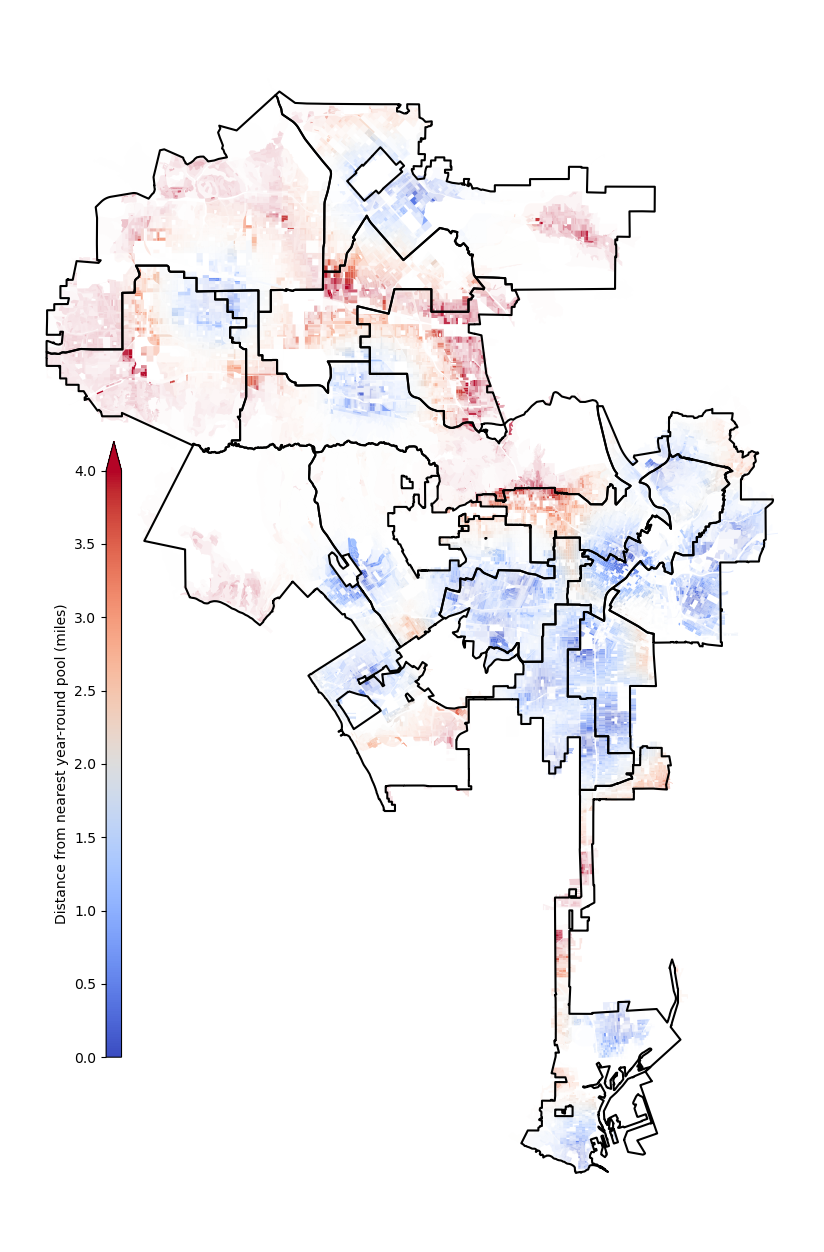

In [19]:
fig, ax = plt.subplots(1,1, figsize=(16,16))
plt.axis("off")
x = (
    geopandas
    .sjoin_nearest(
        la_blocks_with_districts_dedup.to_crs(epsg=2229),
        year_round_all.to_crs(epsg=2229),
        distance_col="distance",
    )
    .to_crs(epsg=4326)
)
x.plot(
    ax=ax,
    column=x["distance"]/5280.,
    cmap="coolwarm",
    legend=True,
    vmin=0,
    vmax=RADIUS*2/5280.,
    figsize=(16,16),
    alpha=x.density.clip(0, 50_000)/50_000,
    legend_kwds={
        "orientation": "vertical",
        "label": "Distance from nearest year-round pool (miles)",
        "shrink": 0.5,
        "aspect": 40,
        "pad": -.2,
        "location": "left",
        "anchor": (0.2, 0.3),
        "extend": "max",
    }
)
districts.boundary.plot(
    ax=ax,
    color="k"
)
fig.savefig("year_round_access.png", bbox_inches="tight")

In [20]:
scenario_pools = (
    pandas.concat(
        [
            year_round_all,
            pools[
                #pools.Aquatic_Center.str.contains("Griffith") |
                (pools.Aquatic_Center.str.contains("Hollywood") &
                ~pools.Aquatic_Center.str.contains("North")) # No North Hollywood
            ],
            community_colleges.iloc[0:1],
        ],
        axis=0,
    )
    .set_crs(epsg=4326)
)

In [21]:
scenario_pool_access_pop = (
    la_blocks_with_districts_dedup[
        la_blocks_with_districts_dedup
        .intersects(
            scenario_pools
            .to_crs(epsg=2229)
            .buffer(RADIUS)
            .to_crs(epsg=4326)
            .unary_union
        )
    ]
    .groupby(["Council District", "Councilmember"])
    .POP20
    .sum()
    .sort_values()
    .rename("scenario_access_pop")
)
scenario_pool_access_pop

Council District  Councilmember          
6                 Vacant                      21680.0
2                 Paul Krekorian              22397.0
12                John Lee                    38860.0
3                 Bob Blumenfield             72704.0
15                Tim McOsker                130180.0
7                 Monica Rodriguez           138046.0
4                 Nithya Raman               180673.0
11                Traci Park                 182231.0
5                 Katy Yaroslavsky           210140.0
1                 Eunisses Hernandez         226938.0
9                 Curren D. Price Jr.        234060.0
14                Kevin de León              240561.0
13                Hugo Soto-Martinez         251948.0
8                 Marqueece Harris-Dawson    261944.0
10                Heather Hutt               262467.0
Name: scenario_access_pop, dtype: float64

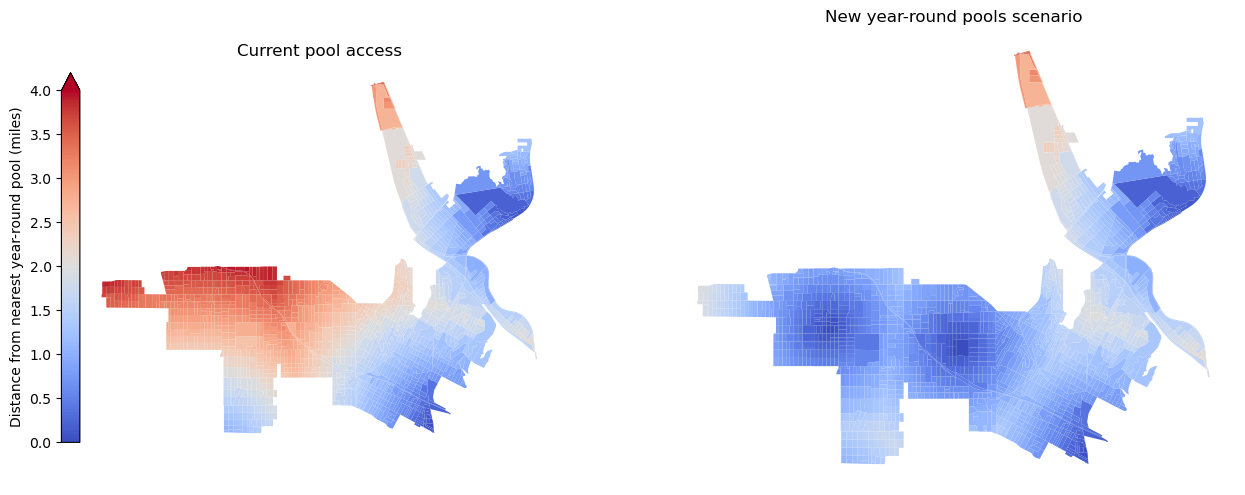

In [31]:
x_before = (
    geopandas
    .sjoin_nearest(
        la_blocks_with_districts_dedup[
            la_blocks_with_districts_dedup["Council District"] == 13
        ].to_crs(epsg=2229),
        year_round_all.to_crs(epsg=2229),
        distance_col="distance",
    )
)
x_after = (
    geopandas
    .sjoin_nearest(
        la_blocks_with_districts_dedup[
            la_blocks_with_districts_dedup["Council District"] == 13
        ].to_crs(epsg=2229),
        scenario_pools.to_crs(epsg=2229),
        distance_col="distance",
    )
)
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,8))
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("Current pool access")
ax2.set_title("New year-round pools scenario")
x_before.plot(
    ax=ax1,
    column=x_before["distance"]/5280.,
    cmap="coolwarm",
    legend=True,
    vmin=0,
    vmax=RADIUS*2/5280.,
    figsize=(16,16),
    alpha=1.,
    legend_kwds={
        "orientation": "vertical",
        "label": "Distance from nearest year-round pool (miles)",
        "shrink": 0.6,
        "aspect": 20,
        "pad": 0.,
        "location": "left",
        "extend": "max",
    }
    
)
x_after.plot(
    ax=ax2,
    column=x_after["distance"]/5280.,
    cmap="coolwarm",
    #legend=True,
    vmin=0,
    vmax=RADIUS*2/5280.,
    figsize=(16,16),
    alpha=1.,
)

fig.savefig("cd13.png", bbox_inches="tight")

In [23]:
total_population_by_district = (
    la_blocks_with_districts_dedup
    .groupby(["Council District", "Councilmember"])
    .POP20
    .sum()
    .rename("total_pop")
)
total_population_by_district

Council District  Councilmember          
1                 Eunisses Hernandez         246375.0
2                 Paul Krekorian             252817.0
3                 Bob Blumenfield            257852.0
4                 Nithya Raman               272735.0
5                 Katy Yaroslavsky           279231.0
6                 Vacant                     260301.0
7                 Monica Rodriguez           272386.0
8                 Marqueece Harris-Dawson    264086.0
9                 Curren D. Price Jr.        265049.0
10                Heather Hutt               269538.0
11                Traci Park                 287375.0
12                John Lee                   260653.0
13                Hugo Soto-Martinez         256008.0
14                Kevin de León              276068.0
15                Tim McOsker                280413.0
Name: total_pop, dtype: float64

In [24]:
report = (
    pandas.concat([
        total_pool_access_pop,
        year_round_pool_access_pop,
        scenario_pool_access_pop,
        pools_by_district,
        total_population_by_district,
        ],
        axis=1
    )
    .assign(
        percent_access_pop = lambda df: 100.*df.year_round_access_pop/df.total_pop,
        scenario_percent_access_pop = lambda df: 100.*df.scenario_access_pop/df.total_pop,
    )
)
report.sort_values("scenario_percent_access_pop")

,,access_pop,year_round_access_pop,scenario_access_pop,year_round,pools,total_pop,percent_access_pop,scenario_percent_access_pop
Council District,Councilmember,,,,,,,,
6,Vacant,206668.0,21680.0,21680.0,0,3,260301.0,8.328819,8.328819
2,Paul Krekorian,247506.0,22397.0,22397.0,0,2,252817.0,8.858977,8.858977
12,John Lee,183447.0,38860.0,38860.0,0,2,260653.0,14.908710,14.908710
3,Bob Blumenfield,239099.0,72704.0,72704.0,0,3,257852.0,28.196019,28.196019
15,Tim McOsker,218129.0,130180.0,130180.0,2,4,280413.0,46.424381,46.424381
7,Monica Rodriguez,220934.0,138046.0,138046.0,2,4,272386.0,50.680285,50.680285
11,Traci Park,259682.0,182231.0,182231.0,1,5,287375.0,63.412266,63.412266
4,Nithya Raman,199496.0,121261.0,180673.0,2,2,272735.0,44.461107,66.244890
5,Katy Yaroslavsky,264120.0,192691.0,210140.0,1,4,279231.0,69.007739,75.256687


In [25]:
html = (
    report
    [["percent_access_pop", "year_round", "pools"]]
    .sort_values("percent_access_pop")
    .assign(percent_access_pop=report.percent_access_pop.round().astype(int))
    .rename(columns={
        "percent_access_pop": "Population under two miles from a year-round pool",
        "pools": "Pools",
        "year_round": "Year-round pools",
    })
).reset_index().style.hide(axis="index").format({
    "Population under two miles from a year-round pool": "{:,.0f}%".format
}).to_html()

print(html)

<style type="text/css">
</style>
<table id="T_a46ca">
  <thead>
    <tr>
      <th id="T_a46ca_level0_col0" class="col_heading level0 col0" >Council District</th>
      <th id="T_a46ca_level0_col1" class="col_heading level0 col1" >Councilmember</th>
      <th id="T_a46ca_level0_col2" class="col_heading level0 col2" >Population under two miles from a year-round pool</th>
      <th id="T_a46ca_level0_col3" class="col_heading level0 col3" >Year-round pools</th>
      <th id="T_a46ca_level0_col4" class="col_heading level0 col4" >Pools</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_a46ca_row0_col0" class="data row0 col0" >6</td>
      <td id="T_a46ca_row0_col1" class="data row0 col1" >Vacant</td>
      <td id="T_a46ca_row0_col2" class="data row0 col2" >8%</td>
      <td id="T_a46ca_row0_col3" class="data row0 col3" >0</td>
      <td id="T_a46ca_row0_col4" class="data row0 col4" >3</td>
    </tr>
    <tr>
      <td id="T_a46ca_row1_col0" class="data row1 col0" >2</td>
      <td

### Which pool is the highest-priority to open year-round?

In [26]:
total_pop = la_blocks_with_districts_dedup.POP20.sum()

In [27]:
total_access_pop = (
    la_blocks_with_districts_dedup[
        la_blocks_with_districts_dedup
        .intersects(
            year_round_all
            .to_crs(epsg=2229)
            .buffer(RADIUS)
            .to_crs(epsg=4326)
            .unary_union
        )
    ]
    .POP20
    .sum()
)
total_access_pop

2213451.0

In [28]:
candidates = pandas.concat([pools,community_colleges]).set_crs(epsg=4326)

In [29]:
records = []

for _, pool in candidates.iterrows():
    if pool.Aquatic_Center not in list(year_round.Aquatic_Center):
        scenario = pandas.concat([
            year_round_all,
            candidates[candidates.Aquatic_Center == pool.Aquatic_Center]
        ])
        one_pool_reopen_access_pop = (
            la_blocks_with_districts_dedup[
                la_blocks_with_districts_dedup
                .intersects(
                    scenario
                    .to_crs(epsg=2229)
                    .buffer(RADIUS)
                    .to_crs(epsg=4326)
                    .unary_union
                )
            ]
            .POP20
            .sum()
        )
        records.append({
            "Council_District": pool.Council_District,
            "Aquatic_Center": pool.Aquatic_Center,
            "Additional_Population": one_pool_reopen_access_pop - total_access_pop,
        })

additional_pool_access = pandas.DataFrame.from_records(records).sort_values("Additional_Population", ascending=False)

KeyboardInterrupt: 

In [ ]:
html = (
    additional_pool_access.astype({
        "Additional_Population": int
    })
    .rename(columns=lambda s: s.replace("_", " "))
    .style
    .hide(axis="index")
    .format({"Additional Population": "{:,.0f}"})
    .to_html()
)

print(html)

### What if we make the top-five priorities year-round? 

In [ ]:
new_year_round_pools = candidates[
    (candidates.Aquatic_Center.str.strip() == "Los Angeles City College") |
    (candidates.Aquatic_Center.str.strip() == "Sepulveda Pool") |
    (candidates.Aquatic_Center.str.strip() == "Hollywood Pool") |
    (candidates.Aquatic_Center.str.strip() == "Valley Plaza Pool") |
    (candidates.Aquatic_Center.str.strip() == "North Hollywood Pool")
]
new_year_round_pools_scenario = pandas.concat([
    year_round_all,
    new_year_round_pools,
])

In [ ]:
new_year_round_pools_scenario_access_pop = (
    la_blocks_with_districts_dedup[
        la_blocks_with_districts_dedup
        .intersects(
            new_year_round_pools_scenario
            .to_crs(epsg=2229)
            .buffer(RADIUS)
            .to_crs(epsg=4326)
            .unary_union
        )
    ]
    .POP20
    .sum()
)
new_year_round_pools_scenario_access_pop - total_access_pop

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.set_axis_off()
ax.set_title("Blue: existing year-round pools\nRed: highest-impact pools to convert to year-round")
year_round_all.to_crs(epsg=2229).buffer(RADIUS).to_crs(epsg=4326).plot(ax=ax, color="b", alpha=0.3)
new_year_round_pools.to_crs(epsg=2229).buffer(RADIUS).to_crs(epsg=4326).plot(ax=ax, color="r", alpha=0.3)
districts.boundary.plot(ax=ax, color="k")